## What is time series?

Time series is a collection of data points collected at *constant time intervals*. It is used to determine long term trends to forecast the future or perform some form of analysis. So how different is TS to regression?

* 1. It is **time dependent**, where the basic assumption of linear regression model that the observations are independent doesn't hold in this case.
* 2. TS mostly have **seasonality trends**.

This is an initial piece to be exposed to the idea of the following concepts in performing time series forecasting
   * Stationarity
   * Dicky Fuller Test
   * Estimating & Eliminating trends and seasonality via differencing and decomposition
   * ACF & PCF
   * Building ARIMA
   
The notes were based on tutorials found on Analytics Vidhya, Mastery Machine Learning and various other sources

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 30, 15

In [2]:
url = 'https://raw.githubusercontent.com/aarshayj/Analytics_Vidhya/master/Articles/Time_Series_Analysis/AirPassengers.csv'
data = pd.read_csv(url)
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [3]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


For time series to work, our *month column needs to be index*

**index_col:** A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. So this argument tells pandas to use the ‘Month’ column as index.

In [4]:
data = pd.read_csv(url, parse_dates=['Month'], index_col='Month')

# lets have a look at the index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [5]:
#convert to time series:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

### Indexing exercise

In [6]:
ts['1949-01-01']

112

In [7]:
#1. Specify the entire range:
ts['1949-01-01':'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [8]:
#2. Use ':' if one of the indices is at ends:
ts[:'1949-05-01']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
Name: #Passengers, dtype: int64

In [9]:
#All rows of 1949:
ts['1949']

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
1949-11-01    104
1949-12-01    118
Name: #Passengers, dtype: int64

## What is stationary and how to check for it?
A TS is said to be stationary if its statistical properties such as **mean, variance and autocovariance** remain constant over time. A stationarized series is relatively easy to predict: you simply predict that its statistical properties will be the same in the future as they have been in the past!The predictions for the stationarized series can then be "untransformed," by reversing whatever mathematical transformations were previously used, to obtain predictions for the original series. Thus, finding the sequence of transformations needed to stationarize a time series often provides important clues in the search for an appropriate forecasting model. Most business and economic time series are far from stationary when expressed in their original units of measurement, and even after deflation or seasonal adjustment they will typically still exhibit trends, cycles, random-walking, and other non-stationary behavior.


**Stationary Process:** A process that generates a stationary series of observations.

**Stationary Model:** A model that describes a stationary series of observations.

**Trend Stationary:** If the series has a stable long-run trend and tends to revert to the trend line following a disturbance, it may be possible to stationarize it by de-trending (e.g., by fitting a trend line and subtracting it out prior to fitting a model

**Seasonal Stationary:** A time series that does not exhibit seasonality

**Difference-stationary:** sometimes even de-trending is not sufficient to make the series stationary, in which case it may be necessary to transform it into a series of period-to-period and/or season-to-season differences.  If the mean, variance, and autocorrelations of the original series are not constant in time, even after detrending, perhaps the statistics of the changes in the series between periods or between seasons will be constant. 

>If we fit a stationary model to data, we assume our data are a realization of a stationary process. So our first step in an analysis should be to check whether there is any evidence of a trend or seasonal effects and, if there is, remove them.

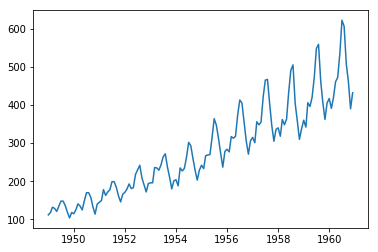

In [10]:
plt.plot(ts)

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations. 

### Ways to check for Stationarity
   * **Look at plots:** review a time series plot of your data and visually check if there are any obvious trends or seasonality
   * **Summary Statistics:** review the summary statistics for your data for seasons or random partitions and check for obvious or significant differences
   * **Statistical Test:** use statistical tests to check if the expectations of stationarity are met or have been violated

**Augmented Dickey-Fuller Test:** This is one of the statistical tests for checking stationarity, also knowned as **unit root test**. The intuition is that it determines how strongly a time series is defined by a trend 

   * **Null Hypothesis ($H_o$):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
   
   * **Alternate Hypothesis ($H_1$):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

   * **p-value > 0.05:** Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
   * **p-value <=0.05:** Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [11]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean() # 12 month window, backwards mean
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

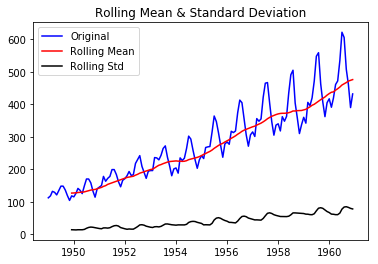

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [12]:
test_stationarity(ts)

Though the variation in standard deviation is small, mean is clearly increasing with time and this is not a stationary series. Also, the test statistic is way more than the critical values. 

### How to interpret the Dickey-Fuller Test?

   * **Test Statistic:** The more negative this statistic, the more likely we are to reject the $H_o$ (we have a stationary dataset)
   * **Critical Value:** Our test statistics is bigger than our critical value at 5% (0.815 > -2.88), fail to reject $H_o$ (we have a time dependent structure
   
   

## So what now? How to make our TS Stationary?
   * **Trend:** varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
   * **Seasonality:** variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals
   
   
   * 1. Estimate the trend and seasonality in the series and remove them to get a stationary series
   * 2. Implement statistical forecasting techniques on this series
   * 3. final step - convert forecasted values into original scale by applying trend and seasonality constraints back


### Estimating & eliminating trends

**Transformation** can be used to reduce trends. Its clear than there is a significant positive trend. So we can apply transformation which penalize higher values more than smaller values. Lets use *log transform*.

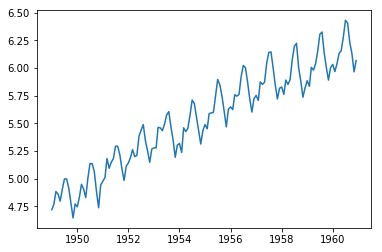

In [13]:
ts_log = np.log(ts)
plt.plot(ts_log)

Its obvious that there is an upward trend but not very intuitive due to noise. There are techniques to estimate or model this trend and then remove it from the series. The following are various ways to doing it.

   * **Aggregation:** taking average for a time period like monthly/weekly averages
   * **Smoothing:** taking rolling averages
   * **Polynomial Fitting:** fit a regression model
   
**Lets try Moving Average**
we take average of ‘k’ consecutive values depending on the frequency of time series. Here we can take the average over the past 1 year, i.e. last 12 values.

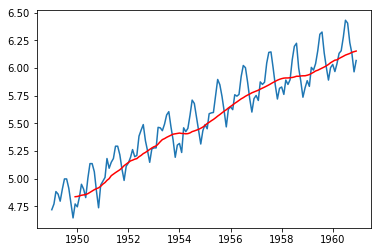

In [14]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values.

In [15]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

# Notice the first 11 being Nan. Lets drop these NaN values and check the plots to test stationarity.

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

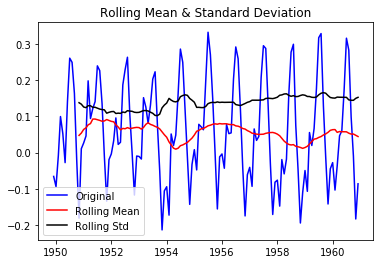

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [16]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

Compare this plot to the previous one where it was still showing an upward trend, this plot's rolling mean shows no significant trend anymore. the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series :)

**Draw Back of Moving Average**
the time-period has to be strictly defined.In this case we can take yearly averages but in complex situations like forecasting a stock price, its difficult to come up with a number. *Weighted moving average* is a solution where more recent values are given a higher weight. **Exponentially weighted moving average** where weights are assigned to all the previous values with a decay factor. 

[Reference for Exponentially Weighted Windows](https://pandas.pydata.org/pandas-docs/stable/user_guide/computation.html)

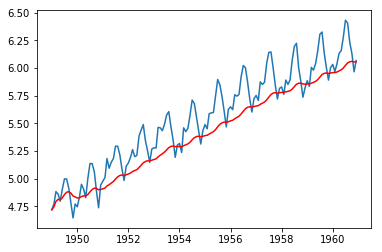

In [17]:
#using the parameter 'halflife' to define the amount of exponential decay
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

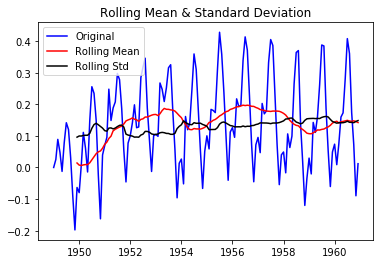

Results of Dickey-Fuller Test:
Test Statistic                  -3.601262
p-value                          0.005737
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [18]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

This TS has even lesser variations in mean and standard deviation in magnitude. Also, the test statistic is smaller than the 1% critical value, which is better than the previous case.

### Eliminating Trend and Seasonality
If your data has both trend and seasonality, removing trend alone is not sufficient, you need to eliminate seasonality as well. There are 2 ways to elimate trend and seasonality.

   * Differencing: taking the difference with a particular time lag
   * Decomposition: modeling both trend and seasonlity and removing them from the model
   
#### Differencing
Differencing is the most common method in dealing with both trend and seasonility.

> Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) trend and seasonality.



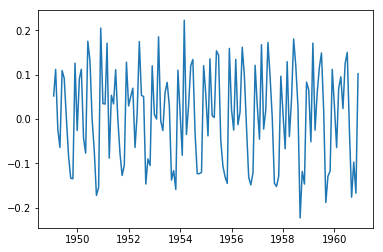

In [19]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

# for shift function
# https://www.geeksforgeeks.org/python-pandas-dataframe-shift/
# looks like the trend is reduced considerably

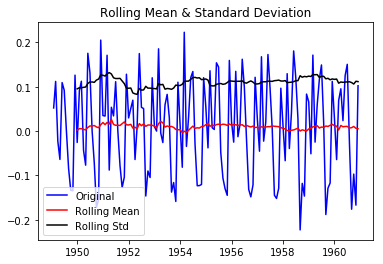

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [20]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

# the Dickey-Fuller test statistic is less than the 10% critical value, thus the TS is stationary with 90% confidence.

### Decomposing

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components. TS can be broken down into systematic & unsystematic components.

   * **Systematic:** Components of the time series that have consistency or recurrence and can be described and modeled.
       * **Level:** The average value in the series
       * **Trend:** The increasing or decreasing value in the series
       * **Seasonality:** The repeating short-term cycle in the series
   * **Non-Systematic:** Components of the time series that cannot be directly modeled.
       * **Noise:** The random variation in the series
       
A series is thought to be an aggregate or combination of these four components. All series have a level and noise. The trend and seasonility components are optional. It is helpful to think of the components as combining either *additively* or multiplicatively.

##### Additive Model
An additive model suggests that the components are added together. It is linear where changes are consistently made by the same amount. A linear trend is a straight line. A linear seasonality has the same frequency (width of cycle) and amplitude (height of cycles)

y(t) = Level + Trend + Seasonality + Noise

##### Multiplicative model
A multiplicative model suggests that the components are multiplied together. It is non linear, such as quadratic or exponential. Changes increase or decrease over time. A nonlinear trend is a curved line and has increasing or decreasing frequency and/or amplitude over time.

y(t) = Level * Trend * Seasonality * Noise

<span style = 'color:red'>**Decomposition** </span> provides a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in a given model. Each of these components are something you may need to think about and address during data preparation, model selection, and model tuning. You may address it explicitly in terms of modeling the trend and subtracting it from your data, or implicitly by providing enough history for an algorithm to model a trend if it may exist.

*statsmodels library* provides an implementation of the naive, or classical, decomposition method in a function called <span style = 'color:blue'>seasonal_decompose()</span>. It requires that you specify whether the model is additive or multiplicative

[Reference](https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/)

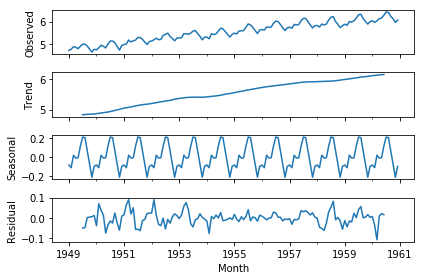

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)
decomposition.plot()
plt.show()

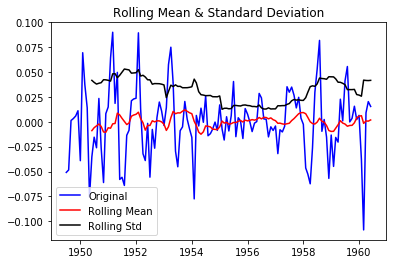

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [22]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# The Dickey-Fuller test statistic is significantly lower than the 1% critical value. So this TS is very close to stationary.

### Forecasting a Time Series

Having performed the trend and seasonality estimation techniques, there can be two situations:
   * A **strictly stationary series** with no dependence among the values. This is the easy case wherein we can model the residuals as white noise. But this is very rare.
   * A series with **significant dependence** among values. In this case we need to use some statistical models like ARIMA to forecast the data.


#### ARIMA (Auto-Regressive Integrated Moving Averages)
The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model.
   * <span style = 'color:green'>**p(Number of AR (Auto-Regressive) terms):**</span> AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
   * <span style = 'color:green'>**q(Number of MA (Moving Average) terms):**</span> MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
   * <span style = 'color:green'>**d(Number of Differences):**</span> These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.
   
#### So how to decide the values for p,q and d?
We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an <span style = 'color:blue'>autocorrelation</span>. Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.


**Autocorrelation Function (ACF):** It is a measure of the correlation between the the TS with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).

**Partial Autocorrelation Function (PCF):** This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. Eg at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 

> The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

### Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k. We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information. This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened. We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k. This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

### Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k. Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated. For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards. Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

[reference](https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/)

In [23]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# using data by differencing
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

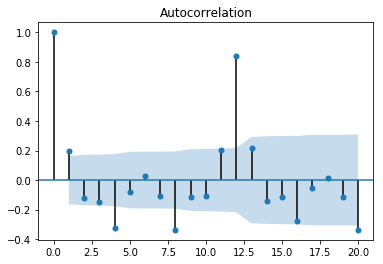

In [24]:
plot_acf(ts_log_diff, lags=20)
plt.show()

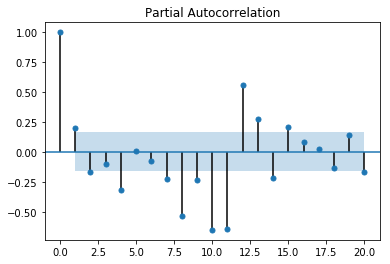

In [25]:
plot_pacf(ts_log_diff, lags=20)
plt.show()

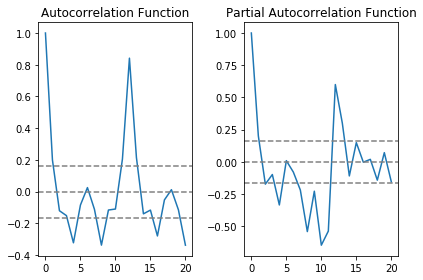

In [26]:
################## Or alternatively ####################
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

<span style = 'color:red'>**p**</span>: The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2

<span style = 'color:red'>**q**</span>: The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.

### Time to build ARIMA
lets make 3 different ARIMA models considering individual as well as combined effects. The *RSS* here is for the values of the residuals and not actual series. The <span style = 'color:red'>p,d,q</span> values can be specified using the order argument of ARIMA which take a tuple <span style = 'color:red'>(p,d,q)</span>.

1. Build AR Model
2. Build MA Model
3. Combined Model

C:\Users\IanLim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IanLim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

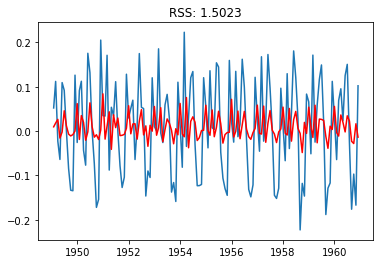

In [28]:
from statsmodels.tsa.arima_model import ARIMA

############ AR Model ############## p,d,q
model = ARIMA(ts_log, order=(2,1,0))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2))

C:\Users\IanLim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IanLim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

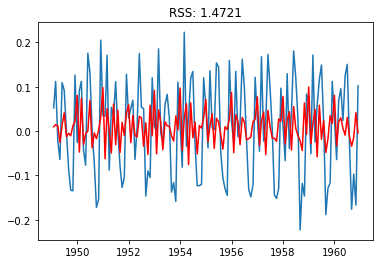

In [29]:
############ MA Model ############## p,d,q
model = ARIMA(ts_log, order=(0,1,2))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2))

C:\Users\IanLim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\IanLim\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

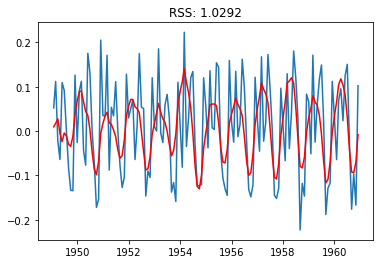

In [30]:
############ Combined Model ############## p,d,q
model = ARIMA(ts_log, order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color = 'red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues - ts_log_diff)**2))

Here we can see that the AR and MA models have almost the same RSS but combined is significantly better. Theres 1 last step to do now, which is converting the values back to the original scale

### Converting back to original scale
Lets use the combined model and scale it back to the original values and see how well it performs. Need to store the predicted results as a separate series and observe it.

In [31]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

See how it starts from 1949-02-01? It is because we took a lag by 1 and first element doesn't have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. Lets do cumulative sum at index and then add it to the base number.

In [33]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-01    0.009580
1949-03-01    0.027071
1949-04-01    0.054742
1949-05-01    0.050221
1949-06-01    0.026331
dtype: float64

In [47]:
ts_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.770685
1949-03-01    4.882802
1949-04-01    4.859812
1949-05-01    4.795791
Name: #Passengers, dtype: float64

Lets create a series with all values as base number and add the differences to it

In [45]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value = 0)
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

Text(0.5, 1.0, 'RMSE: 90.1045')

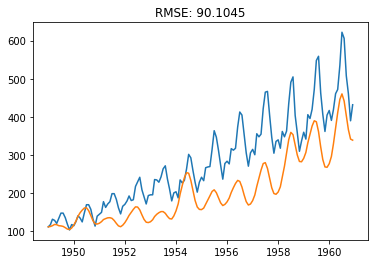

In [48]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA - ts)**2)/len(ts)))

Its not the best fit but this piece is gain a better understanding at 
   * Stationarity
   * Dicky Fuller Test
   * Estimating & Eliminating trends and seasonality via differencing and decomposition
   * ACF & PCF
   * Building ARIMA